In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve

# Set path to your dataset in Google Drive
dataset_dir = '/content/drive/MyDrive/PAPER DATASET/Genitalia1'  # Update with the correct path

Found 1457 files belonging to 6 classes.
In the dataset, there are 25 files belonging to 6 classes.


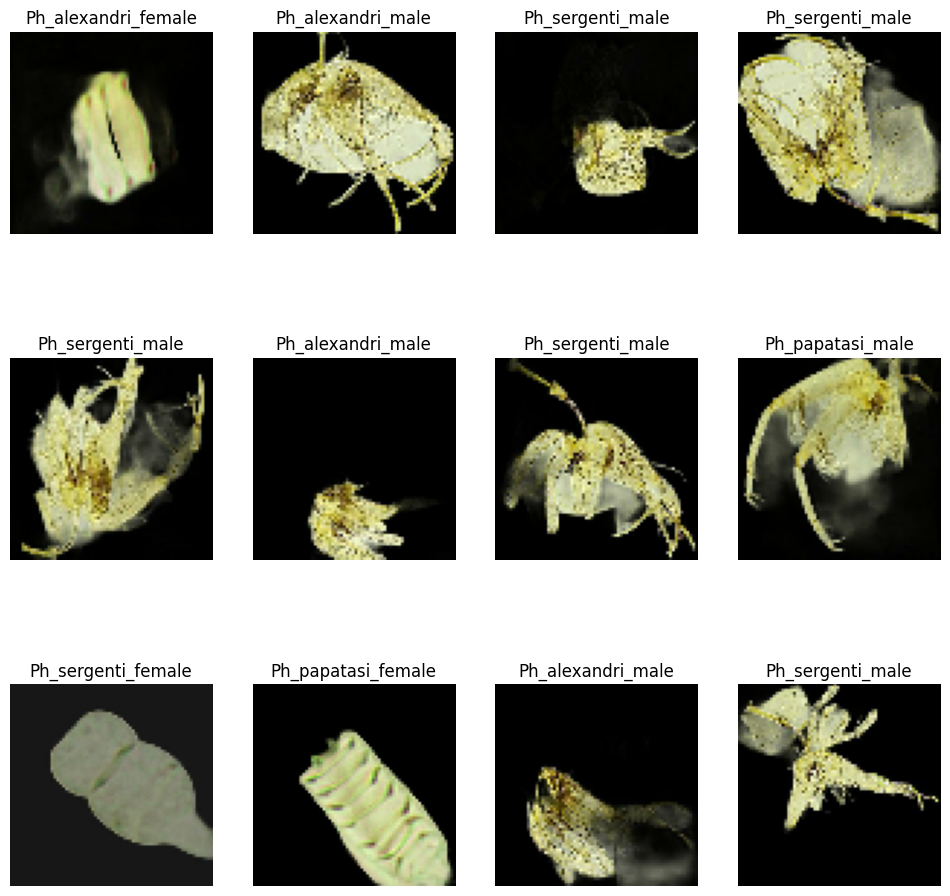

In [3]:

# Set image parameters
IMAGE_SIZE = 70
BATCH_SIZE = 60
CHANNELS = 3
EPOCHS = 100

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(f"In the dataset, there are {len(dataset)} files belonging to {len(class_names)} classes.")

# Display sample images and labels
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# Function to partition the dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Prepare the data for training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define the model architecture
#input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)



In [4]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, BatchNormalization, Add,
                                     Reshape, Multiply, Conv2D, Concatenate, Lambda)
from tensorflow.keras import backend as K


In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K




from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential


f'''rom tensorflow.keras.applications import EfficientNetB2
base_model = EfficientNetB2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)'''

from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)


base_model.trainable = False


# Full model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(n_classes, activation='softmax')
])



input_shape = (70, 70, 3)  # Example
IMAGE_SIZE = 70

#model = customCNN(input_shape, IMAGE_SIZE)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.75,
    patience=2,
    min_lr=0.00001
)

In [7]:
import os

In [8]:
# Train the model
history = model.fit(
    train_ds,
    epochs=200,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[reduce_lr]
)

# Evaluate the model
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.1215 - loss: 1.8453 - val_accuracy: 0.1750 - val_loss: 1.8229 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1816 - loss: 1.8019 - val_accuracy: 0.2000 - val_loss: 1.8226 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1610 - loss: 1.8287 - val_accuracy: 0.1667 - val_loss: 1.8176 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1680 - loss: 1.8081 - val_accuracy: 0.1917 - val_loss: 1.8173 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1706 - loss: 1.8045 - val_accuracy: 0.1750 - val_loss: 1.8090 - learning_rate: 7.5000e-04
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1697 - loss: 1.8026 - val_accuracy: 0.1083 - val_loss: 1.8210 - learning_rate: 7.5000e-04
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1630 - loss: 1

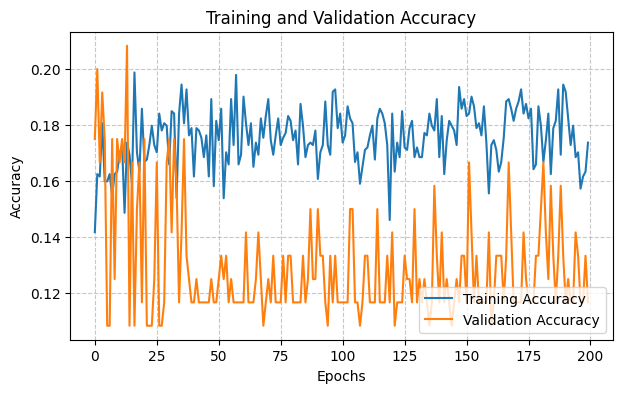

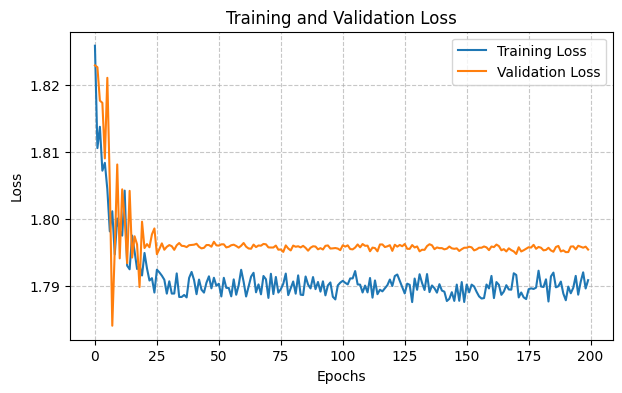

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Plot the training and validation accuracy
plt.figure(figsize=(7, 4))
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(7, 4))
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


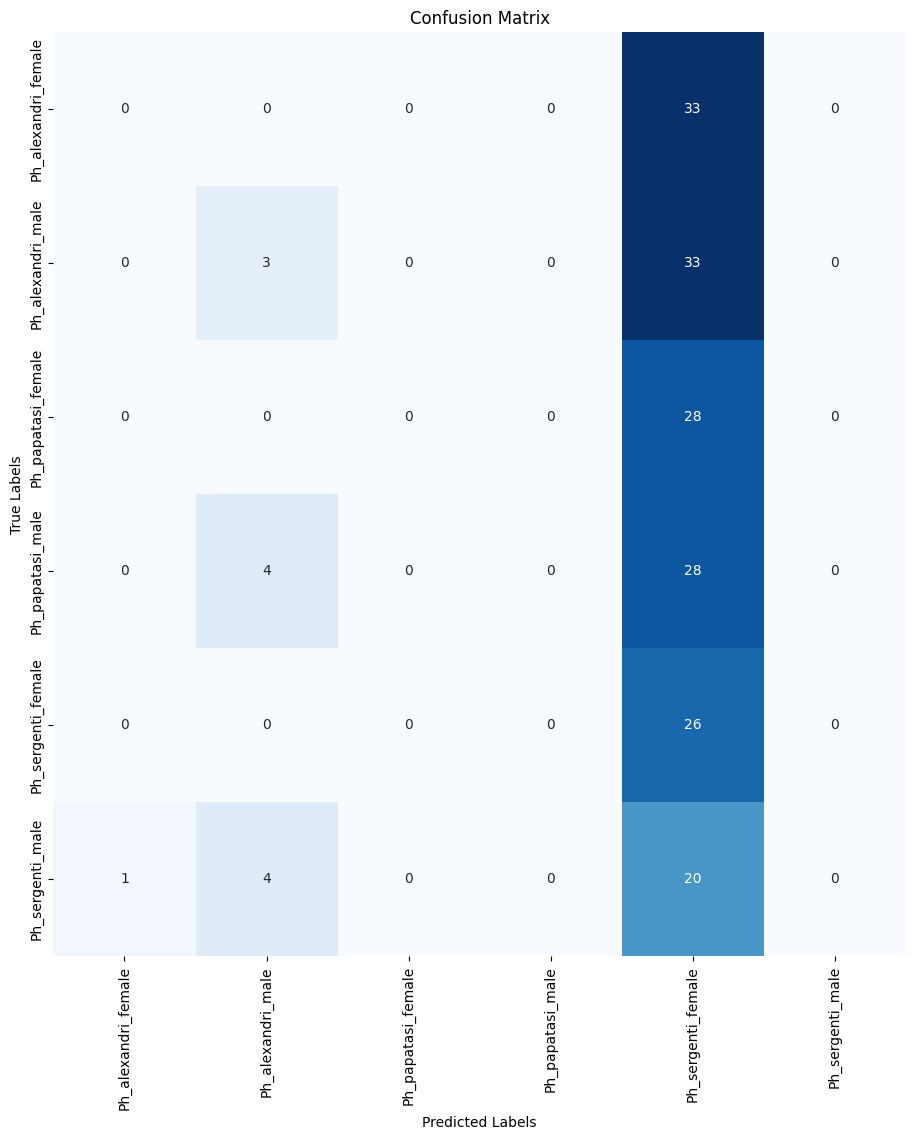

In [10]:
# Make predictions on the test dataset
y_true = []
y_pred = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    y_true.extend(label_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted labels

# Generate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(11, 12))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.show()




In [11]:
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                     precision    recall  f1-score   support

Ph_alexandri_female       0.00      0.00      0.00        33
  Ph_alexandri_male       0.27      0.08      0.13        36
 Ph_papatasi_female       0.00      0.00      0.00        28
   Ph_papatasi_male       0.00      0.00      0.00        32
 Ph_sergenti_female       0.15      1.00      0.27        26
   Ph_sergenti_male       0.00      0.00      0.00        25

           accuracy                           0.16       180
          macro avg       0.07      0.18      0.07       180
       weighted avg       0.08      0.16      0.06       180



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Classification Report:
                     precision    recall  f1-score   support

Ph_alexandri_female       0.00      0.00      0.00        33
  Ph_alexandri_male       0.27      0.08      0.13        36
 Ph_papatasi_female       0.00      0.00      0.00        28
   Ph_papatasi_male       0.00      0.00      0.00        32
 Ph_sergenti_female       0.15      1.00      0.27        26
   Ph_sergenti_male       0.00      0.00      0.00        25

           accuracy                           0.16       180
          macro avg       0.07      0.18      0.07       180
       weighted avg       0.08      0.16      0.06       180



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


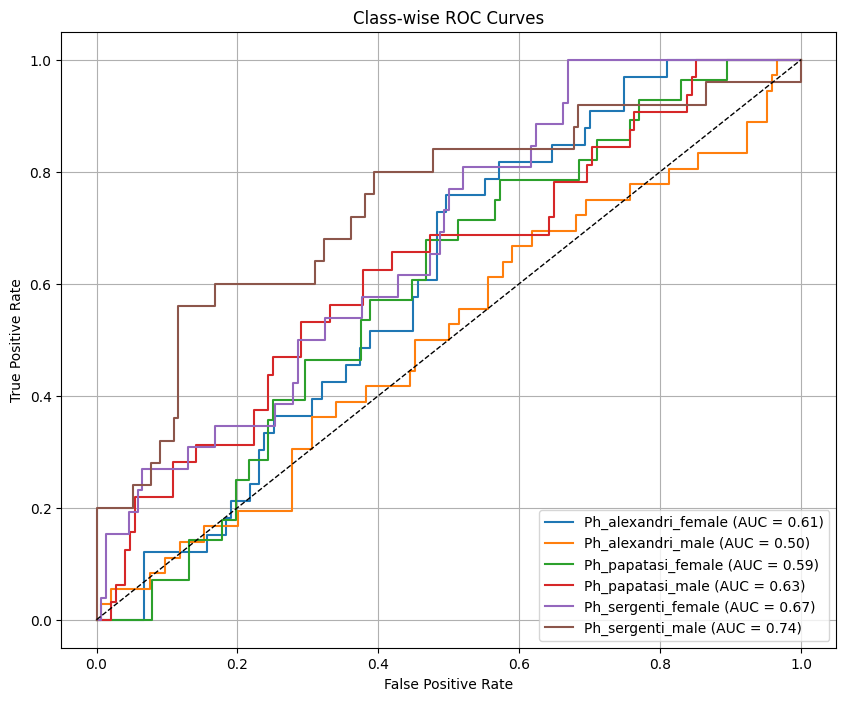

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, jaccard_score
from sklearn.preprocessing import label_binarize

# Make predictions on the test dataset
y_true = []
y_pred = []
y_scores = []  # For ROC curves (probabilities)

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    y_true.extend(label_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted class indices
    y_scores.extend(predictions)  # Keep probabilities for ROC

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Generate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)


# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# -----------------------------
# Compute and plot ROC curves and AUC for each class
# -----------------------------

# Binarize the output for multiclass ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('Class-wise ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Classification Report:
                     precision    recall  f1-score   support

Ph_alexandri_female       0.00      0.00      0.00        33
  Ph_alexandri_male       0.27      0.08      0.13        36
 Ph_papatasi_female       0.00      0.00      0.00        28
   Ph_papatasi_male       0.00      0.00      0.00        32
 Ph_sergenti_female       0.15      1.00      0.27        26
   Ph_sergenti_male       0.00      0.00      0.00        25

           accuracy                           0.16       180
          macro avg       0.07      0.18      0.07       180
       weighted avg       0.08      0.16      0.06       180



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


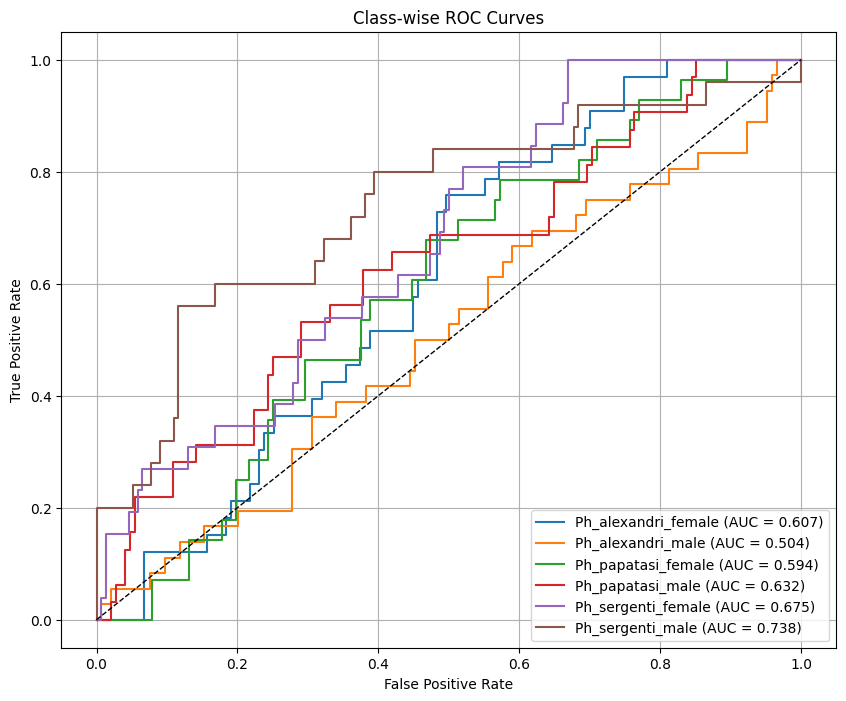

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, jaccard_score
from sklearn.preprocessing import label_binarize

# Make predictions on the test dataset
y_true = []
y_pred = []
y_scores = []  # For ROC curves (probabilities)

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    y_true.extend(label_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted class indices
    y_scores.extend(predictions)  # Keep probabilities for ROC

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Generate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# -----------------------------
# Compute and plot ROC curves and manual AUC for each class
# -----------------------------

# Binarize the output for multiclass ROC
y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])

    # Use np.trapezoid instead of deprecated np.trapz
    roc_auc_manual = np.trapezoid(tpr, fpr)

    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_manual:.3f})')


plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('Class-wise ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [14]:
# -----------------------------
# Compute Jaccard similarity score per class
# -----------------------------

print("\nJaccard Similarity Scores per Class:")

for i, class_name in enumerate(class_names):
    # Jaccard requires binary vectors: treat class i as positive class
    y_true_binary = (y_true == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)
    jaccard = jaccard_score(y_true_binary, y_pred_binary)
    print(f"{class_name}: {jaccard:.4f}")



Jaccard Similarity Scores per Class:
Ph_alexandri_female: 0.0000
Ph_alexandri_male: 0.0682
Ph_papatasi_female: 0.0000
Ph_papatasi_male: 0.0000
Ph_sergenti_female: 0.1548
Ph_sergenti_male: 0.0000
